In [1]:
import torch
import requests
from PIL import Image
from io import BytesIO
from transformers import CLIPProcessor, CLIPModel

# Define Reference Images
reference_images = [
    {
        "url": "https://images.unsplash.com/reserve/bOvf94dPRxWu0u3QsPjF_tree.jpg?q=80&w=1776&auto=format&fit=crop&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D",
        "tags": ["tree", "nature"],
    },
    {
        "url": "https://images.unsplash.com/photo-1437964706703-40b90bdf563b?q=80&w=1974&auto=format&fit=crop&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D",
        "tags": ["tree", "forest"],
    },
    {
        "url": "https://images.unsplash.com/photo-1444312645910-ffa973656eba?q=80&w=1887&auto=format&fit=crop&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D",
        "tags": ["rock", "outdoor"],
    },
]

# Load CLIP Model
model_ckpt = "openai/clip-vit-base-patch32"
clip_model = CLIPModel.from_pretrained(model_ckpt)
clip_processor = CLIPProcessor.from_pretrained(model_ckpt)

device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model = clip_model.to(device).eval()

# Compute Reference Image Embeddings
ref_embeddings = []
for ref in reference_images:
    url = ref["url"]
    tags = ref["tags"]
    try:
        resp = requests.get(url)
        if resp.status_code == 200:
            img = Image.open(BytesIO(resp.content)).convert("RGB")
            
            # Preprocess for CLIP
            inputs = clip_processor(images=img, return_tensors="pt").to(device)
            
            with torch.no_grad():
                # Get image embeddings and normalize
                image_embeds = clip_model.get_image_features(**inputs)
                image_embeds = image_embeds / image_embeds.norm(p=2, dim=-1, keepdim=True)
            
            ref_embeddings.append({
                "image_url": url,
                "tags": tags,
                "embedding": image_embeds.squeeze(0)  # shape: (512,)
            })
        else:
            print(f"Failed to fetch image {url} - status: {resp.status_code}")
    except Exception as e:
        print(f"Error loading {url}: {e}")

print("Reference image embeddings computed:", len(ref_embeddings))


Reference image embeddings computed: 3


Text(value='rock', description='Query:', placeholder='Enter query text')

IntSlider(value=3, description='Top K:', max=3, min=1)

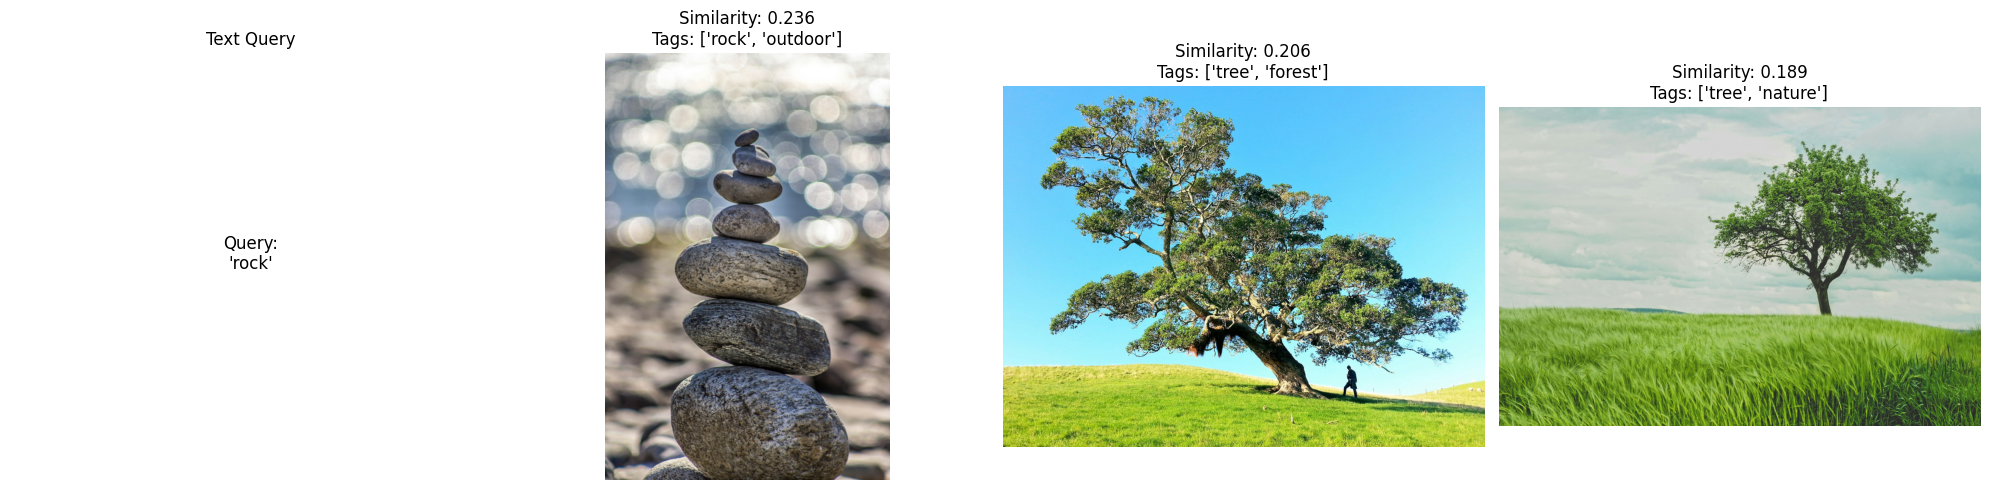

In [2]:
import torch
import matplotlib.pyplot as plt
from PIL import Image
import requests
from io import BytesIO
import ipywidgets as widgets
from IPython.display import display

# Function to perform text-based querying
def query_images_with_text(query_text, top_k=3):
    """
    Given a text query, find and display the top_k most similar images from the reference set.
    
    Args:
        query_text (str): The text query string.
        top_k (int): Number of top similar images to retrieve.
    """
    # 1. Embed the text query using CLIP's text encoder
    text_inputs = clip_processor(text=[query_text], return_tensors="pt").to(device)
    
    with torch.no_grad():
        text_embeds = clip_model.get_text_features(**text_inputs)
        text_embeds = text_embeds / text_embeds.norm(p=2, dim=-1, keepdim=True)
    
    # 2. Compute similarity scores with all reference image embeddings
    similarities = []
    for ref in ref_embeddings:
        sim_score = torch.matmul(text_embeds, ref["embedding"])
        similarities.append(sim_score.item())
    
    # 3. Get top_k indices based on similarity scores
    top_k_indices = sorted(range(len(similarities)), key=lambda i: similarities[i], reverse=True)[:top_k]
    
    # 4. Display the query and top_k similar images
    num_images = top_k + 1  # +1 for the query description
    fig, axes = plt.subplots(1, num_images, figsize=(5 * num_images, 5))
    
    # Display the query text
    axes[0].text(0.5, 0.5, f"Query:\n'{query_text}'", fontsize=12, ha='center', wrap=True)
    axes[0].axis('off')
    axes[0].set_title("Text Query")
    
    # Display the top_k similar images
    for idx, ref_idx in enumerate(top_k_indices):
        ref = ref_embeddings[ref_idx]
        sim_score = similarities[ref_idx]
        img_url = ref["image_url"]
        tags = ref["tags"]
        
        try:
            resp = requests.get(img_url)
            if resp.status_code == 200:
                img = Image.open(BytesIO(resp.content)).convert("RGB")
                axes[idx + 1].imshow(img)
                axes[idx + 1].axis("off")
                axes[idx + 1].set_title(f"Similarity: {sim_score:.3f}\nTags: {tags}")
            else:
                axes[idx + 1].set_title(f"Failed to fetch image.\nStatus: {resp.status_code}")
                axes[idx + 1].axis("off")
        except Exception as e:
            axes[idx + 1].set_title(f"Error loading image.\n{e}")
            axes[idx + 1].axis("off")
    
    plt.tight_layout()
    plt.show()

# Interactive widget for text input
text_query = widgets.Text(
    value='rock',
    placeholder='Enter query text',
    description='Query:',
    disabled=False
)

# Widget for selecting top_k
top_k_slider = widgets.IntSlider(
    value=3,
    min=1,
    max=len(ref_embeddings),
    step=1,
    description='Top K:',
    disabled=False
)

# Function to update the display based on widget interaction
def on_query_change(change):
    query = change['new']
    query_images_with_text(query, top_k_slider.value)

# Function to update when top_k changes
def on_topk_change(change):
    query = text_query.value
    query_images_with_text(query, change['new'])

# Attach listeners
text_query.observe(on_query_change, names='value')
top_k_slider.observe(on_topk_change, names='value')

# Display widgets
display(text_query, top_k_slider)

# Initial display
query_images_with_text(text_query.value, top_k_slider.value)
